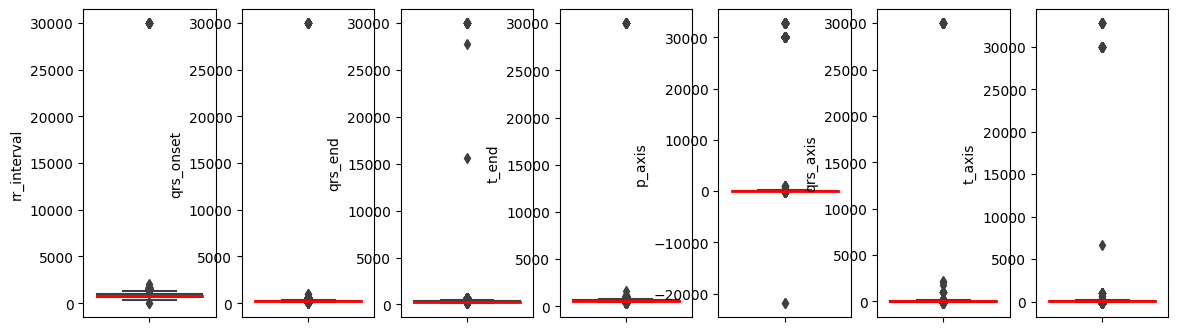

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# 1. Load the dataset (replace with your actual CSV path)
df = pd.read_csv('module_2.csv')

# 2. Select columns of interest (all should be strictly positive if using a log scale)
features = ['rr_interval', 'qrs_onset', 'qrs_end', 't_end', 'p_axis', 'qrs_axis', 't_axis']

df_boxplot = df[features]

n = df_boxplot.shape[1]
fig,ax = plt.subplots(1,n, figsize=(n*2,4), sharex=True)
for i in range(n):
    plt.sca(ax[i])
    col = df_boxplot.columns[i]
    sns.boxplot(y = df_boxplot.iloc[:,i],data=df_boxplot, medianprops={"color": "r", "linewidth": 2})

Выводы: есть выбросы

In [4]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec

#  A) Remove outliers in certain numeric columns
columns_to_filter = ['rr_interval', 'p_onset', 'p_end', 'qrs_onset', 'qrs_end', 't_end', 'p_axis', 'qrs_axis', 't_axis']
full_df_filtered = df[(df[columns_to_filter] < 2000).all(axis=1)]
full_df_filtered = full_df_filtered[
    (full_df_filtered['p_onset'] < full_df_filtered['p_end']) &
    (full_df_filtered['qrs_onset'] < full_df_filtered['qrs_end'])
]

#  B) Merge all textual reports into one column
reports = [f'report_{x}' for x in range(18)]
full_df_filtered['report_0'] = (
    full_df_filtered[reports]
    .astype(str)
    .agg(' '.join, axis=1)
)
full_df_filtered['report_0'] = (
    full_df_filtered['report_0']
    .str.replace(r'\bnan\b', '', regex=True)
    .str.replace(r'\s+', ' ', regex=True)
    .str.strip()
)
full_df_filtered.rename(columns={'report_0': 'report'}, inplace=True)
reports_to_drop = [f'report_{x}' for x in range(1, 18)]
full_df_filtered = full_df_filtered.drop(reports_to_drop, axis=1)

#  C) Rename columns 'eeg_time ', 'eeg_date ' => 'eeg_time', 'eeg_date'
full_df_filtered = full_df_filtered.rename(columns={'eeg_time ': 'eeg_time', 'eeg_date ': 'eeg_date'})

#  D) Drop columns bandwidth, filtering
full_df_filtered = full_df_filtered.drop(columns=['bandwidth', 'filtering'])

#  E) Move 'Healthy_Status' to the far right
full_df_filtered = full_df_filtered[
    [col for col in full_df_filtered.columns if col != 'Healthy_Status'] + ['Healthy_Status']
]

#  F) Tokenize 'report' column
words = [text.split() for text in full_df_filtered['report']]

#  G) Train a Word2Vec model
w2v_model = Word2Vec(words)

#  H) Convert each 'report' to the mean embedding => single float
def get_sentence_embedding(sentence):
    tokens = sentence.split()
    word_vectors = [w2v_model.wv[tok] for tok in tokens if tok in w2v_model.wv]
    if word_vectors:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(w2v_model.vector_size)

full_df_filtered['report'] = full_df_filtered['report'].apply(lambda x: get_sentence_embedding(x).mean())

# Final result
print("\n=== Final DataFrame after snippet ===")
display(full_df_filtered)


=== Final DataFrame after snippet ===


subject_id  Count_subj  study_id  cart_id  eeg_time    eeg_date  \
0       19557662          27  40000017  6848296   8:44 AM  27.06.2015   
1       18477137          93  40000029  6848296   9:54 AM  27.06.2015   
2       16598616           3  40000035  6376932   9:07 AM  28.06.2015   
3       16368287           7  40000079  6214760   5:14 PM  15.07.2015   
6       12576058          43  40000115  6852956  12:54 PM  23.03.2016   
...          ...         ...       ...      ...       ...         ...   
9994    15837443          40  40125246  6602038   8:39 AM  04.04.2016   
9995    19612562          29  40125255  6752764  11:26 AM  12.04.2016   
9996    14816795           1  40125256  6555070   6:01 PM  12.04.2016   
9998    13871862           2  40125273  6848296   5:38 PM  03.01.2011   
9999    14747544          12  40125285  6848296  11:58 PM  03.01.2011   

        report  rr_interval  p_onset  p_end  qrs_onset  qrs_end  t_end  \
0     0.035701          659       40    128        170      258    518   
1     0.035701          722       40    124        162      246    504   
2    -0.010583          600       40    130        162      244    474   
3     0.000802          659       40    146        180      254    538   
6     0.000802          952       40    146        198      282    598   
...        ...          ...      ...    ...        ...      ...    ...   
9994  0.000802          769       40    166        214      302    592   
9995  0.000802          606       40    162        204      298    526   
9996  0.000802          606       40    160        202      294    534   
9998  0.000802          789       40    158        192      288    592   
9999  0.006085          923       40    158        200      292    630   

      p_axis  qrs_axis  t_axis  Healthy_Status  
0         81        77      79               0  
1         77        75      70               0  
2         79        72      77               1  
3         79        66      69               1  
6         24        80      20               1  
...      ...       ...     ...             ...  
9994      55        60      68               1  
9995      64        68      66               1  
9996      70        73      66               1  
9998      43        14      15               1  
9999      30        20      13               0  

[7046 rows x 17 columns]

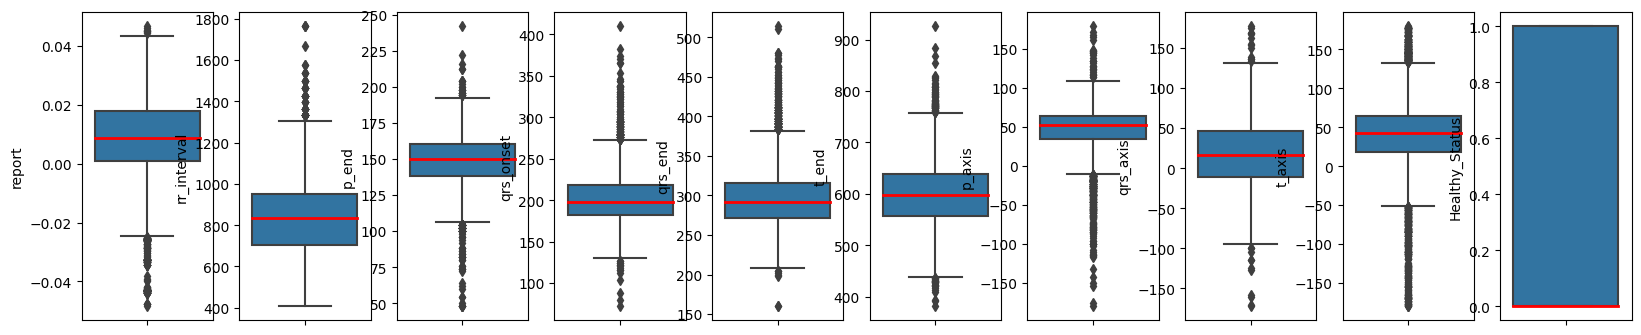

In [5]:
table_data = full_df_filtered[['report','rr_interval','p_end','qrs_onset','qrs_end','t_end','p_axis','qrs_axis','t_axis','Healthy_Status']].copy()
table_data.head()


n = table_data.shape[1]
fig,ax = plt.subplots(1,n, figsize=(n*2,4), sharex=True)
for i in range(n):
    plt.sca(ax[i])
    col = table_data.columns[i]
    sns.boxplot(y = table_data.iloc[:,i],data=table_data, medianprops={"color": "r", "linewidth": 2})

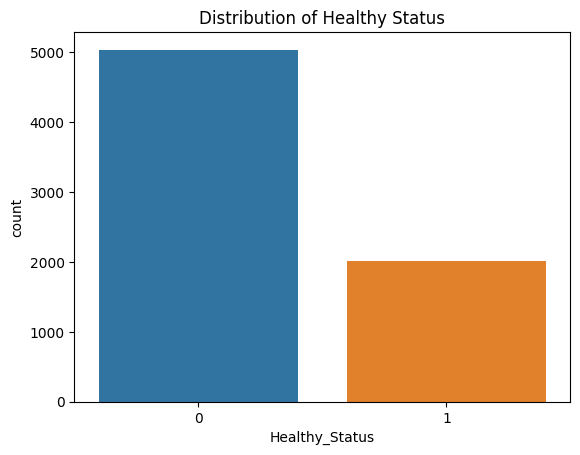

In [6]:
sns.countplot(data=table_data, x="Healthy_Status")
plt.title("Distribution of Healthy Status")
plt.show()

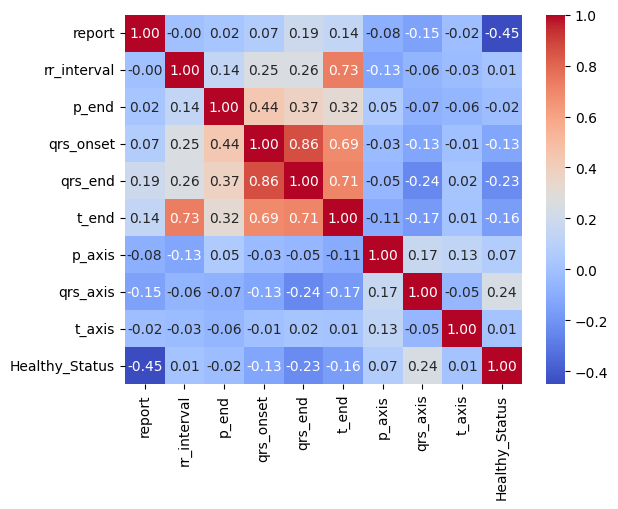

In [7]:
sns.heatmap(table_data.corr(),annot=True,fmt="0.2f",cmap="coolwarm")
plt.show()

`qrs_onset` и `qrs_end`: высокая положительная корреляция (~0,86). Очевидно, так как это время начала и окончания QRS.

`qrs_onset` и `t_end` также показывают значительную корреляцию (~0,69). Задержка начала QRS часто сопровождает задержку завершения зубца T в одном и том же сердечном сокращении.

`t_end` против `rr_interval`: корреляция около ~0,73 предполагает, что субъекты с более длинными интервалами RR (т. е. более медленным ритмом сердца) также склонны иметь дольшое время T-волны

<Axes: xlabel='rr_interval', ylabel='t_end'>

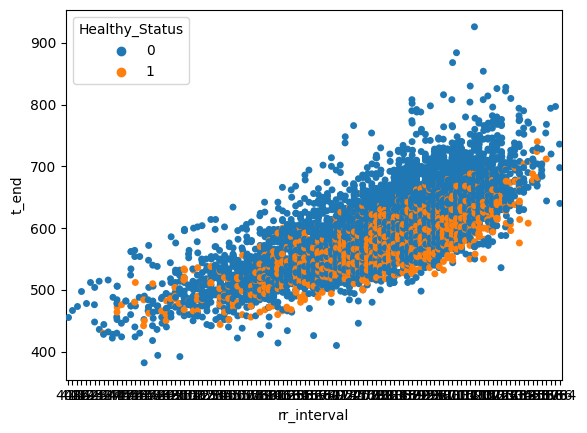

In [8]:
sns.stripplot(x=table_data['rr_interval'],y=table_data['t_end'],
              hue=table_data['Healthy_Status'],jitter=True)

/opt/homebrew/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


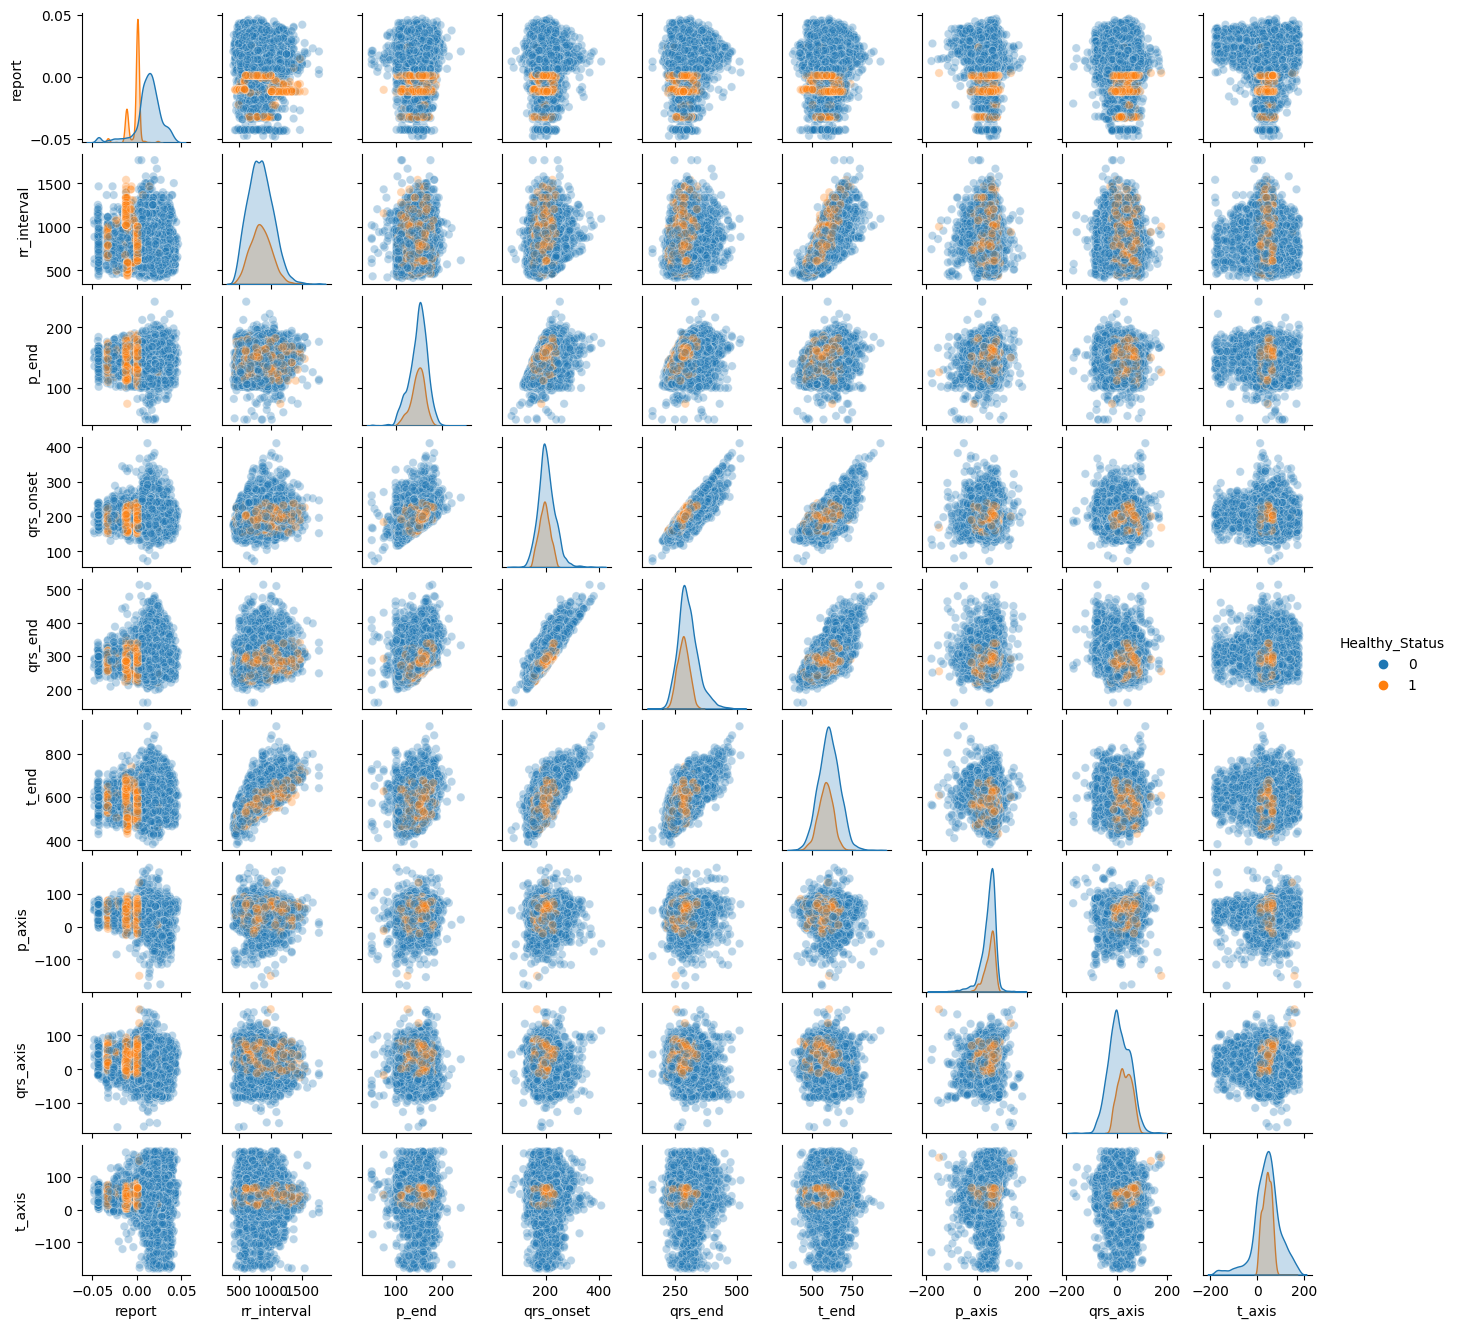

In [9]:
#labels = pd.DataFrame(table_data['Healthy_Status'])
sns.pairplot(table_data, hue = "Healthy_Status",
             height=1.5,
             plot_kws=dict(alpha=0.3))

## Обработка данных: PCA, ICA, t-SNE

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [12]:
#table_data_pca = full_df_filtered
table_data_pca = table_data
table_data_pca = table_data_pca.drop('Healthy_Status', axis = 1)

# Before applying PCA, each feature should be centered (zero mean) and with unit variance
scaled_data = StandardScaler().fit(table_data_pca).transform(table_data_pca)
pca = PCA(n_components = 2).fit(scaled_data)
# PCA(copy=True, n_components=2, whiten=False)
x_pca = pca.transform(scaled_data)
print(table_data.shape, x_pca.shape)

(7046, 10) (7046, 2)


In [13]:
percent = pca.explained_variance_ratio_
print(percent)
print(sum(percent))
#To see how much variance is preserved for each dataset.

[0.34459705 0.13791298]
0.482510035581453


In [14]:
def pca_explained(X, threshold):
  features = X.shape[1]
  for i in range(2, features):
    pca = PCA(n_components = i).fit(X)
    sum_ = pca.explained_variance_ratio_
    # add all components explained variances
    percent = sum(sum_)
    print('{} components at {:.2f}% explained variance'.format(i,percent*100))
    if percent > threshold:
      break

pca_explained(scaled_data, 0.85)

2 components at 48.25% explained variance
3 components at 60.80% explained variance
4 components at 72.29% explained variance
5 components at 82.02% explained variance
6 components at 90.14% explained variance


Text(0, 0.5, 'Second Principal Component')

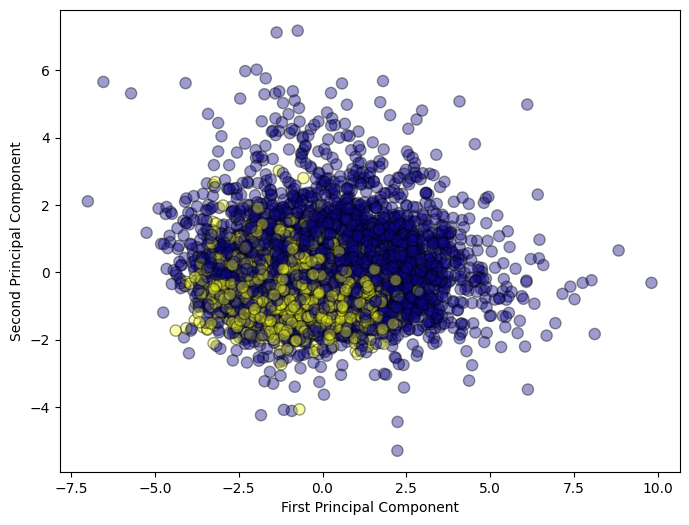

In [15]:
plt.figure(figsize=(8,6))
plt.scatter(x_pca[:,0], x_pca[:,1], c=full_df_filtered['Healthy_Status'], cmap='plasma', alpha=0.4, edgecolors='black', s=65);
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

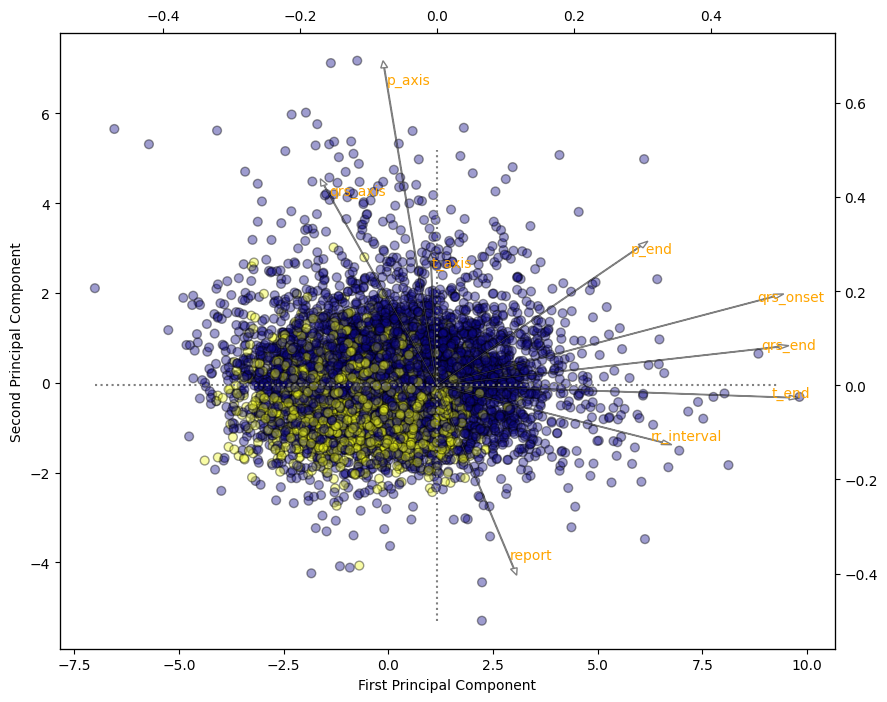

In [16]:
# put feature values into dataframe
components = pd.DataFrame(pca.components_.T, index=table_data_pca.columns, columns= ['PCA1','PCA2'])
# plot size
plt.figure(figsize=(10,8))
# main scatterplot
plt.scatter(x_pca[:,0], x_pca[:,1], c=full_df_filtered['Healthy_Status'],
            cmap='plasma', alpha=0.4, edgecolors='black', s=40);
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
#plt.ylim(15,-15);
#plt.xlim(20,-20);

# individual feature values
ax2 = plt.twinx().twiny();
#ax2.set_ylim(-0.5,0.5);
#ax2.set_xlim(-0.5,0.5);

# reference lines
ax2.hlines(0,-0.5,0.5, linestyles='dotted', colors='grey')
ax2.vlines(0,-0.5,0.5, linestyles='dotted', colors='grey')

# offset for labels
offset = 0.95
# arrow & text
for a, i in enumerate(components.index):
  ax2.arrow(0, 0, components['PCA1'][a], -components['PCA2'][a], alpha=0.5, facecolor='white', head_width=.01)
  ax2.annotate(i, (components['PCA1'][a]*offset, -components['PCA2'][a]*offset), color='orange')

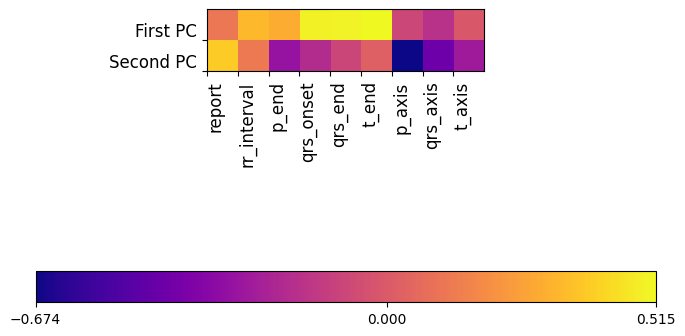

In [17]:
fig = plt.figure(figsize=(8, 4))
plt.imshow(pca.components_, interpolation = 'none', cmap = 'plasma')
feature_names = list(table_data_pca.columns)
plt.gca().set_xticks(np.arange(-.5, len(feature_names)-1));
plt.gca().set_yticks(np.arange(0.5, 2));
plt.gca().set_xticklabels(feature_names, rotation=90, ha='left',fontsize=12);
plt.gca().set_yticklabels(['First PC', 'Second PC'], va='bottom',fontsize=12);
plt.colorbar(orientation='horizontal', ticks=[pca.components_.min(), 0,
                                              pca.components_.max()],pad=0.65);

Text(0, 0.5, 'Second Principal Component')

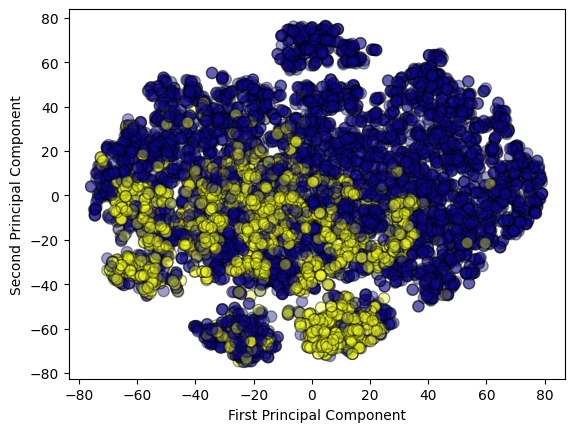

In [18]:
from sklearn.manifold import TSNE
tsne = TSNE(random_state = 0)
scaled_data_tsne = tsne.fit_transform(scaled_data)
plt.scatter(scaled_data_tsne[:,0], scaled_data_tsne[:,1], c=full_df_filtered['Healthy_Status'], cmap='plasma', alpha=0.4, edgecolors='black', s=65);
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

In [19]:
from sklearn import manifold
from time import time

Time code evaluation for perplexity=1 in 16 sec
Time code evaluation for perplexity=5 in 16 sec
Time code evaluation for perplexity=10 in 16 sec
Time code evaluation for perplexity=15 in 17 sec
Time code evaluation for perplexity=20 in 18 sec
Time code evaluation for perplexity=30 in 19 sec
Time code evaluation for perplexity=40 in 21 sec
Time code evaluation for perplexity=50 in 20 sec
Time code evaluation for perplexity=100 in 24 sec


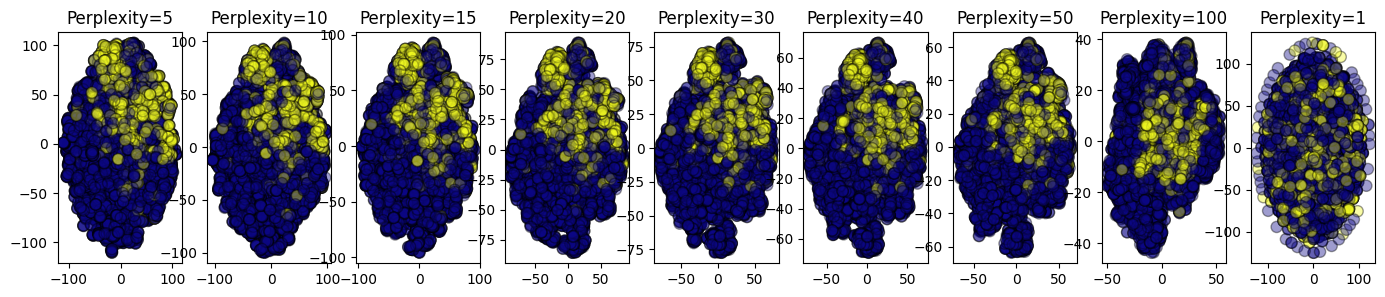

In [22]:
n_components = 2
perplexities = [1, 5, 10, 15, 20, 30, 40, 50, 100]
#perplexities = [5, 10]

(fig, subplots) = plt.subplots(1, len(perplexities), figsize=(17, 3))

for i, perplexity in enumerate(perplexities):
    ax = subplots[i-1]

    t0 = time()
    tsne = manifold.TSNE(
        n_components=n_components,
        init="random",
        random_state=0,
        perplexity=perplexity,
        n_iter_without_progress=300,
        )

    scaled_data_tsne = tsne.fit_transform(scaled_data)
    t1 = time()

    print("Time code evaluation for perplexity=%d in %.2g sec" % (perplexity, t1 - t0))

    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(scaled_data_tsne[:,0], scaled_data_tsne[:,1],
               c=full_df_filtered['Healthy_Status'],
               cmap='plasma',
               alpha=0.4,
               edgecolors='black',
               s=65
               );
    ax.axis("tight")

In [30]:
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_decision_regions
from sklearn.naive_bayes import GaussianNB

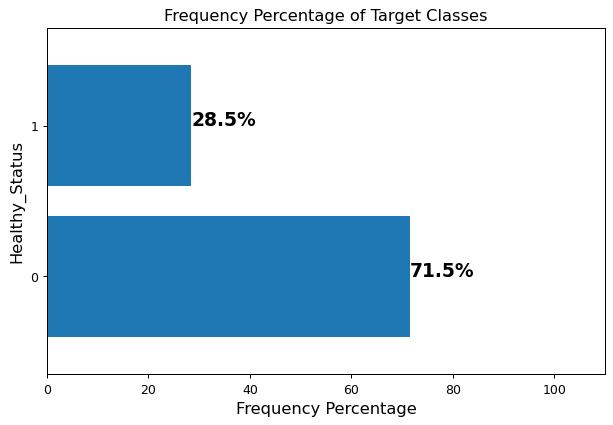

In [31]:
clf_index = 9

plt.figure(figsize=(35,20),dpi=90)
# Plot frequency percentages barplot
table_data[table_data.columns[clf_index]].value_counts(normalize=True).mul(100).plot(kind='barh', width=0.8, figsize=(8,5))

# Add frequency percentages to the plot
labels = table_data[table_data.columns[clf_index]].value_counts(normalize=True).mul(100).round(1)
for i in labels.index:
    plt.text(labels[i], i, str(labels[i])+ '%', fontsize=15, weight='bold')

plt.xlim([0, 110])
plt.xlabel('Frequency Percentage', fontsize=13)
plt.ylabel(table_data.columns[clf_index], fontsize=13)
plt.title('Frequency Percentage of Target Classes', fontsize=13)
plt.show()

In [32]:
# classification variable
y1 = table_data.iloc[:, clf_index]
# input variable
X1 = table_data.drop(table_data.columns[[clf_index]], axis=1).iloc[:,:]

y1 = pd.Series(LabelEncoder().fit_transform(y1))
X1_train, X1_test, y1_train, y1_test = train_test_split(X1.values,
                                                        y1.values,
                                                        test_size=0.3,
                                                        random_state=0,
                                                        stratify=y1.values)

In [33]:
X_train,X_test,y_train,y_test = train_test_split(X1.values,
                                                 y1.values,
                                                 test_size=0.3,
                                                 random_state=41,
                                                 stratify=y1.values)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (4932, 9)
y_train shape: (4932,)
X_test shape: (2114, 9)
y_test shape: (2114,)


In [34]:
GussianClassifier = GaussianNB()
GussianClassifier.fit(X1_train,y1_train)
y_pred=GussianClassifier.predict(X_test)
print("===================================> Result <===================================")
print("Accuracy                     = " ,metrics.accuracy_score(y_test,y_pred))
print("F1 Score                     = " ,metrics.f1_score(y_test,y_pred))

===================================> Result <===================================
Accuracy                     =  0.8301797540208137
F1 Score                     =  0.7448471926083866


In [35]:
from sklearn.metrics import ConfusionMatrixDisplay

              precision    recall  f1-score   support

        True       0.94      0.81      0.87      1512
       False       0.65      0.87      0.74       602

    accuracy                           0.83      2114
   macro avg       0.80      0.84      0.81      2114
weighted avg       0.86      0.83      0.84      2114



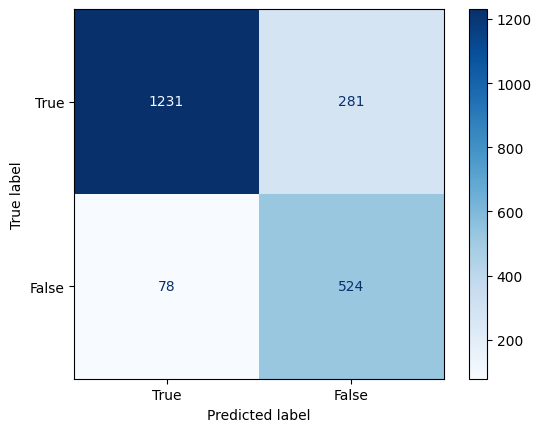

In [36]:
target_names = ['True', 'False']
labels_names = [0,1]
print(classification_report(y_test, y_pred,labels=labels_names, target_names=target_names))
#cm = confusion_matrix(y_test, y_pred,labels=labels_names,normalize='true')
cm = confusion_matrix(y_test, y_pred,labels=labels_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=target_names)
disp = disp.plot(cmap=plt.cm.Blues,values_format='g')
plt.show()

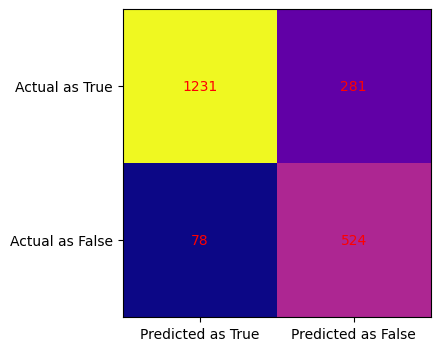

In [37]:
cm = confusion_matrix(y_test,GussianClassifier.predict(X_test))

fig , ax  = plt.subplots(figsize=(4,4))
ax.imshow(cm, cmap = 'plasma')
ax.grid(False)
ax.xaxis.set(ticks=(0,1),ticklabels=("Predicted as True","Predicted as False"))
ax.yaxis.set(ticks=(0,1),ticklabels=("Actual as True","Actual as False"))
ax.set_ylim(1.5,-0.5)
for i in range(2):
    for j in range(2):
        ax.text(j,i,cm[i,j],ha="center",va="center",color = "red")

In [38]:
autoML_df = full_df_filtered[['report', 'rr_interval', 'p_end', 'qrs_onset', 'qrs_end', 't_end', 'p_axis', 'qrs_axis', 't_axis', 'Healthy_Status']].copy()

In [41]:
import h2o
from h2o.frame import H2OFrame
from h2o.automl import H2OAutoML
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, roc_auc_score

# Инициализируем H2O
h2o.init()

# Переводим датафрейм в формат H2OFrame
h2o_df = H2OFrame(autoML_df)

# Разбиение на обучающую и тестовую выборки
random_seed = 17
train, test = h2o_df.split_frame(ratios=[0.85], seed=random_seed)

# Определяем целевую переменную и предикторы
y="Healthy_Status"
x = list(h2o_df.columns)
x.remove(y)

# Создаем и обучаем модель H2O AutoML
automl = H2OAutoML(max_runtime_secs=60, seed=random_seed, verbosity="info")
#automl= H2OAutoML(max_models = 10, seed = 10, exclude_algos = ["StackedEnsemble", "DeepLearning"], verbosity="info", nfolds=0)


automl.train(x=x, y=y, training_frame=train)

# Оценка модели на тестовом наборе
performance = automl.leader.model_performance(test_data=test)
print(performance)

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.22" 2024-01-16; OpenJDK Runtime Environment Temurin-11.0.22+7 (build 11.0.22+7); OpenJDK 64-Bit Server VM Temurin-11.0.22+7 (build 11.0.22+7, mixed mode)
  Starting server from /opt/homebrew/anaconda3/lib/python3.9/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/0x/7trbc4q971j0l3ls57fgz5rr0000gn/T/tmp749fb1ae
  JVM stdout: /var/folders/0x/7trbc4q971j0l3ls57fgz5rr0000gn/T/tmp749fb1ae/h2o_kodor_started_from_python.out
  JVM stderr: /var/folders/0x/7trbc4q971j0l3ls57fgz5rr0000gn/T/tmp749fb1ae/h2o_kodor_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  -----------------------------
H2O_cluster_uptime:         01 secs
H2O_cluster_timezone:       Europe/Moscow
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.46.0.7
H2O_cluster_version_age:    15 days
H2O_cluster_name:           H2O_from_python_kodor_dr2kyq
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    4 Gb
H2O_cluster_total_cores:    10
H2O_cluster_allowed_cores:  10
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://127.0.0.1:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
Python_version:             3.9.13 final
--------------------------  -----------------------------

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
10:23:53.750: Project: AutoML_1_20250412_102353
10:23:53.751: 5-fold cross-validation will be used.
10:23:53.751: Setting stopping tolerance adaptively based on the training frame: 0.012934759914813772
10:23:53.751: Build control seed: 17
10:23:53.751: training frame: Frame key: AutoML_1_20250412_102353_training_py_2_sid_8322    cols: 10    rows: 5977  chunks: 1    size: 138901  checksum: 8727864609478125025
10:23:53.751: validation frame: NULL
10:23:53.751: leaderboard frame: NULL
10:23:53.751: blending frame: NULL
10:23:53.751: response column: Healthy_Status
10:23:53.751: fold column: null
10:23:53.751: weights column: null
10:23:53.757: AutoML: XGBoost is not available; skipping it.
10:23:53.759: Loading execution steps: [{XGBoost : [def_2 (1g, 10w), def_1 (2g, 10w), def_3 (3g, 10w), grid_1 (4g, 90w), lr_search (6g, 30w)]}, {GLM : [def_1 (1g, 10w)]}, {DRF : [def_1 (2g, 

In [51]:
lb = automl.leaderboard
lb.head()

model_id                                                     rmse        mse        mae      rmsle    mean_residual_deviance
-------------------------------------------------------  --------  ---------  ---------  ---------  ------------------------
StackedEnsemble_AllModels_4_AutoML_1_20250412_102353     0.116104  0.01348    0.0447513  0.0829334                 0.01348
StackedEnsemble_AllModels_3_AutoML_1_20250412_102353     0.116265  0.0135176  0.0447673  0.0830626                 0.0135176
StackedEnsemble_AllModels_2_AutoML_1_20250412_102353     0.118668  0.0140821  0.0445825  0.0851654                 0.0140821
StackedEnsemble_BestOfFamily_4_AutoML_1_20250412_102353  0.119843  0.0143623  0.0465156  0.086703                  0.0143623
GBM_5_AutoML_1_20250412_102353                           0.11986   0.0143664  0.0465232  0.0866992                 0.0143664
StackedEnsemble_BestOfFamily_3_AutoML_1_20250412_102353  0.119885  0.0143724  0.0464851  0.0867089                 0.0143724
GBM_grid_1_AutoML_1_20250412_102353_model_29             0.120384  0.0144924  0.0485164  0.0864493                 0.0144924
StackedEnsemble_AllModels_1_AutoML_1_20250412_102353     0.121015  0.0146446  0.0454503  0.0864983                 0.0146446
GBM_grid_1_AutoML_1_20250412_102353_model_10             0.121727  0.0148174  0.0458209  0.087261                  0.0148174
GBM_grid_1_AutoML_1_20250412_102353_model_21             0.121997  0.0148832  0.0527505  0.0882602                 0.0148832
[10 rows x 6 columns]

In [56]:
model_ids = list(automl.leaderboard['model_id'].as_data_frame().iloc[:,0])
model_ids

/opt/homebrew/anaconda3/lib/python3.9/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


['StackedEnsemble_AllModels_4_AutoML_1_20250412_102353',
 'StackedEnsemble_AllModels_3_AutoML_1_20250412_102353',
 'StackedEnsemble_AllModels_2_AutoML_1_20250412_102353',
 'StackedEnsemble_BestOfFamily_4_AutoML_1_20250412_102353',
 'GBM_5_AutoML_1_20250412_102353',
 'StackedEnsemble_BestOfFamily_3_AutoML_1_20250412_102353',
 'GBM_grid_1_AutoML_1_20250412_102353_model_29',
 'StackedEnsemble_AllModels_1_AutoML_1_20250412_102353',
 'GBM_grid_1_AutoML_1_20250412_102353_model_10',
 'GBM_grid_1_AutoML_1_20250412_102353_model_21',
 'GBM_grid_1_AutoML_1_20250412_102353_model_16',
 'GBM_grid_1_AutoML_1_20250412_102353_model_5',
 'GBM_2_AutoML_1_20250412_102353',
 'StackedEnsemble_BestOfFamily_2_AutoML_1_20250412_102353',
 'GBM_4_AutoML_1_20250412_102353',
 'GBM_grid_1_AutoML_1_20250412_102353_model_30',
 'GBM_grid_1_AutoML_1_20250412_102353_model_4',
 'GBM_3_AutoML_1_20250412_102353',
 'GBM_grid_1_AutoML_1_20250412_102353_model_23',
 'GBM_grid_1_AutoML_1_20250412_102353_model_18',
 'GBM_grid_1_

### XGBoost не работает на ARM ноутбуках Apple https://github.com/h2oai/h2o-3/issues/16515

In [61]:
out = h2o.get_model([mid for mid in model_ids if "GLM_1_AutoML_1_20250412_102353" in mid][0])

In [62]:
automl.leader.model_performance(test)

ModelMetricsRegressionGLM: stackedensemble
** Reported on test data. **

MSE: 0.008179306033661533
RMSE: 0.09043951588582025
MAE: 0.03797547934688678
RMSLE: 0.06491753401887818
Mean Residual Deviance: 0.008179306033661533
R^2: 0.9604992141997858
Null degrees of freedom: 1068
Residual degrees of freedom: 1059
Null deviance: 221.44853674628007
Residual deviance: 8.743678149984179
AIC: -2082.0815947914075

In [63]:
test_predict = automl.predict(test)

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


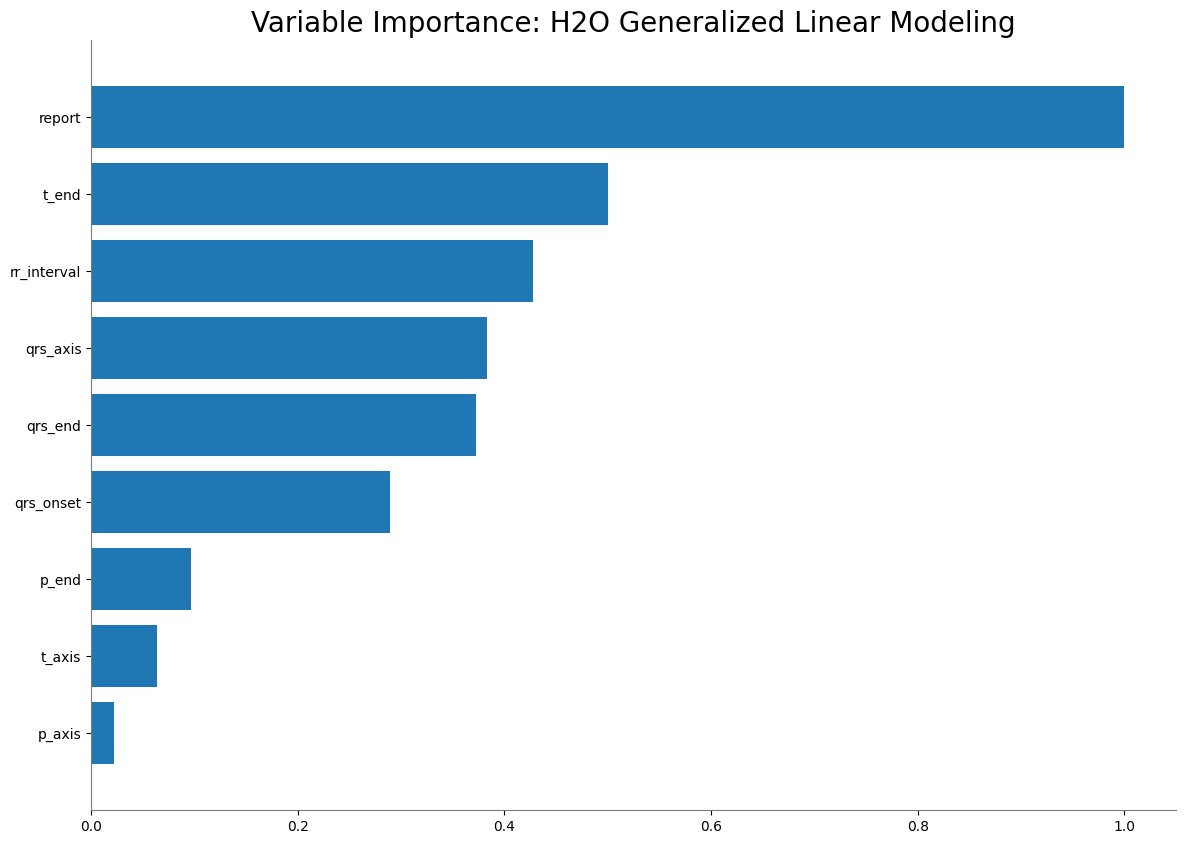

<Figure size 640x480 with 0 Axes>

In [64]:
out.varimp_plot()

In [65]:
# H2OFrame
test_preds = h2o.as_list(test_predict)
test_preds = test_preds['predict']

/opt/homebrew/anaconda3/lib/python3.9/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


In [66]:
test_Y = h2o.as_list(test['Healthy_Status'])
test_Y = test_Y['Healthy_Status']

/opt/homebrew/anaconda3/lib/python3.9/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


In [67]:
# Вычисляем F1-меру с помощью confusion matrix

# Порог отсечения - 0.5
for i in range(len(test_preds)):
  if test_preds[i] > 0.5:
    test_preds[i] = 1
  else:
    test_preds[i] = 0


cm = confusion_matrix(test_Y, test_preds)
TN, FP, FN, TP = cm.ravel()
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
Accuracy = (TP + TN) / (TP + TN + FN + FP)
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

roc_auc = roc_auc_score(test_Y, test_preds)

print("Confusion matrix:", cm)
print("F1-Score: ", "{:.2f}".format(f1_score))
print("Accuracy:", "{:.2f}".format(Accuracy))
print("Recall: ", r"{:.2f}".format(recall))
print("Precision: ","{:.2f}".format(precision))

Confusion matrix: [[755   1]
 [  9 304]]
F1-Score:  0.98
Accuracy: 0.99
Recall:  0.97
Precision:  1.00


In [72]:
# Завершение работы H2O
h2o.shutdown()

/var/folders/0x/7trbc4q971j0l3ls57fgz5rr0000gn/T/ipykernel_87965/387636098.py:2: H2ODeprecationWarning: Deprecated, use ``h2o.cluster().shutdown()``.
  h2o.shutdown()


In [73]:
!pip install pycaret --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mlflow 2.4.1 requires pyarrow<13,>=4.0.0, but you have pyarrow 19.0.1 which is incompatible.


## Вывод о структуре признаков данных

### Общие наблюдения

1. **Последовательная кластеризация временных характеристик** 
 - Несколько графиков (например, тепловые карты и парные графики) показывают, что временные характеристики ЭКГ (например, *rr_interval*, *p_onset*, *p_end*, *qrs_onset*, *qrs_end* и *t_end*) очень сильно коррелируют между собой. Это говорит о том, что многие из этих переменных имеют общую физиологическую основу. Они могут быть в значительной степени избыточными, что означает, что преобразование (например, анализ главных компонент) может отразить большую часть изменчивости в меньшем количестве составных признаков.

2. **Переменные электрической оси образуют отдельную группу** 
 - На тепловых картах измерения оси (*p_axis*, *qrs_axis* и *t_axis*), как правило, имеют более низкие корреляции с временными показателями. На диаграммах рассеяния или при парных сравнениях эти характеристики не следуют такой же жесткой линейной тенденции, как для временных интервалов. Эти показатели отражают ортогональную (или дополнительную) информацию о пространственной ориентации электрической активности сердца. Их включение в прогностическую модель может повысить эффективность за счет охвата различных аспектов сердечного процесса, даже если они не сильно коррелируют друг с другом или временными интервалами.

3. **Эмбеддинги report** 
 - Эмбединги `report` ЭКГ (полученное путем усреднения вкраплений Word2Vec) демонстрирует паттерн, который отличается от остальных числовых данных. На корреляционных тепловых картах она демонстрирует умеренную корреляцию (положительную или отрицательную) с целевой переменной (например, `Healthy_Status`), но очень слабую корреляцию или полное отсутствие корреляции с другими структурированными признаками ЭКГ. Эта функция, вероятно, улавливает качественные сигналы из свободнотекстовых отчетов - например, диагностические впечатления или комментарии, которые могут указывать на патологию, - которые дополняют чисто числовые сигналы ЭКГ.

4. **Паттерны выбросов и распределение данных** 
 - На боксплотах видно, что многие характеристики имеют выбросов. Это указывает на то, что хотя большинство испытуемых попадают в ожидаемый диапазон, есть и экстремальные значения (которые могут быть вызваны ошибкой измерения или реальной патологией).

5. **Мультимодальная структура данных** 
 - При просмотре всех графиков становится очевидным, что набор данных состоит из нескольких «слоев» или модальностей:
     - **Временные измерения:** Сильно взаимосвязанные числовые характеристики (с некоторой избыточностью).
     - **Пространственные/осевые данные:** Характеристики, отражающие информацию о направлении, которая в меньшей степени коррелирует с временными данными.
     - **Репорты:** Неструктурированная информация, преобразованная в числовой вектор, который несет в себе уникальные клинические подсказки.


### Вывод

**Графики указывают на богатую базовую структуру в датасете:**

- **Избыточность временных признаков:** Временные признаки ЭКГ сильно связаны между собой. Это говорит о том, что для последующего анализа могут быть полезны методы, объединяющие эти переменные в меньшее количество суммарных показателей.
  
- Отдельная дополнительная информация:** Показатели электрической оси и встраивание текстового отчета не совпадают с временными характеристиками. Вероятно, они предоставляют независимую информацию, которая крайне важна для отражения различных аспектов здоровья сердца.

- **Обработка выбросов:** Выбросы, видимые в боксплотах, подчеркивают необходимость надежной предварительной обработки, чтобы они не исказили дальнейший анализ.


## Какое из Auto ML решений с этой задачей справилось лучше.

Исходя из значений precision и AUC AdaBoost, LightGBM, and XGBoost показали лучший результат 